In [4]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pathlib import Path
from typing import List
from datetime import datetime
import re
from matplotlib import pyplot
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

CHECKS = pd.read_json('../src/checks.json')
CHECKS = CHECKS.drop(columns=['sram_offset', 'sram_mask', 'conditions'])
CHECKS = CHECKS.rename(columns={'id': 'location_id', 'name': 'check_name'})

EVENTS = pd.read_json('../src/events.json')
EVENTS = EVENTS.drop(columns=['sram_offset', 'sram_mask', 'conditions', 'is_progressive'])
EVENTS = EVENTS.rename(columns={'id': 'event_id', 'name': 'event_name'})

ITEMS = pd.read_json('../src/items.json')
ITEMS = ITEMS.drop(columns=['sram_offset', 'sram_mask', 'conditions', 'is_progressive'])
ITEMS = ITEMS.rename(columns={'id': 'item_id', 'name': 'item_name'})

TILES = pd.read_json('../src/tiles.json')
TILES = TILES.drop(columns=['address_value', 'conditions'])
TILES = TILES.rename(columns={'id': 'tile_id', 'name': 'tile_name'})

DUNGEONS = ['Hyrule Castle', 'Eastern Palace', 'Desert Palace', 'Tower of Hera',
    'Castle Tower', 'Palace of Darkness', 'Swamp Palace', 'Skull Woods',
    'Thieves\' Town', 'Ice Palace', 'Misery Mire', 'Turtle Rock',
    'Ganon\'s Tower']

NONDUNGEONS = ['West Hyrule', 'East Hyrule', 'South Hyrule', 'Central Hyrule',
    'Death Mountain', 'West Dark World', 'East Dark World', 'South Dark World',
    'Central Dark World', 'Dark Death Mountain']

BOSS_TILES = [240, 264, 276, 318, 351, 372, 394, 430, 457, 492]

def timedelta(ms: int) -> str:
    seconds=(ms/1000)%60
    seconds = round(int(seconds), 2)
    minutes=(ms/(1000*60))%60
    minutes = round(int(minutes), 2)
    seconds = str(seconds) if seconds > 9 else str('0') + str(seconds)
    minutes = str(minutes) if minutes > 9 else str('0') + str(minutes)
    return(f"{minutes}:{seconds}")

def read_meta(input_file: str) -> dict:
    meta = {'header': 0}
    with open(input_file) as f:
        while True:
            line = f.readline()
            if line[0] in ['#', '\n']:
                meta['header'] += 1
                if line[0] == '#':
                    line = line.strip().split(' ')
                    meta[line[1]] = ' '.join(line[2:])
            else:
                break
    return meta

def add_info(df: DataFrame) -> DataFrame:
    df = pd.merge(df, TILES, how='left', on=['tile_id'])
    df = pd.merge(df, CHECKS, how='left', on=['location_id'])
    df = pd.merge(df, ITEMS, how='left', on=['item_id'])
    df = pd.merge(df, EVENTS, how='left', on=['event_id'])

    df['timestamp'] = df['timestamp'] - df['timestamp'].min()

    for i,row in df.iterrows():
        event_name = row['event_name']
        if not pd.isna(event_name):
            event_name = re.sub(' - \d{0,9}\d\Z', '', event_name) # Remove the trailing counts for now
            if event_name in ['Save & Quit', 'Reset', 'Death']:
                df.at[i, 'tile_name'] = 'File Select'
                df.at[i, 'region'] = 'None'
                df.at[i, 'indoors'] = np.nan
            elif i > 0:
                df.at[i, 'tile_name'] = df.loc[i-1,]['tile_name']
                df.at[i, 'region'] = df.loc[i-1,]['region']
                df.at[i, 'indoors'] = df.loc[i-1,]['indoors']
                df.at[i, 'killroom'] = df.loc[i-1,]['killroom']
                df.at[i, 'tile_id'] = df.loc[i-1,]['tile_id']
        elif i > 0 and pd.isna(row['tile_name']):
            df.at[i, 'tile_name'] = df.loc[i-1,]['tile_name']
            df.at[i, 'region'] = df.loc[i-1,]['region']
            df.at[i, 'indoors'] = df.loc[i-1,]['indoors']
            df.at[i, 'killroom'] = df.loc[i-1,]['killroom']
            df.at[i, 'tile_id'] = df.loc[i-1,]['tile_id']
    return df

def read_runs(glob_path: str):
    dfs: List[DataFrame] = []
    for path in Path.cwd().glob(glob_path):
        meta = read_meta(path)
        df = pd.read_csv(path, skiprows=meta['header'])
        df = add_info(df)
        df['filename'] = path.name
        dfs.append(df)
    return dfs

def summarise(regions: list, df: DataFrame) -> DataFrame:
    keysanity = False
    s = {}
    for region in regions:
        s[region] = {'time': 0, 'visits': 0, 'checks': 0, 'dungeon_items': 0}

    route = False
    for _,row in df.iterrows():
        current_region = row['region']
        if route and current_region != region:
            route = False
            s[region]['time'] += row['timestamp'] - start_time
            s[region]['visits'] += 1
        if route and not pd.isna(row['check_name']):
            s[region]['checks'] += 1
        if route and not pd.isna(row['item_name']) and row['item_name'] in dungeon_item_names:
            s[region]['dungeon_items'] += 1
        if not route and current_region in regions:
            route = True
            start_time = row['timestamp']
            region = current_region
            if not keysanity:
                dungeon_item_names = []
                dungeon_item_names.append('Small Key - ' + current_region)
                dungeon_item_names.append('Big Key - ' + current_region)
                dungeon_item_names.append('Compass - ' + current_region)
                dungeon_item_names.append('Map - ' + current_region)

    # To make sure the final route in the log actually ends
    if route:
        route = False
        s[region]['time'] += row['timestamp'] - start_time
        s[region]['visits'] += 1

    # Convert to lists of dicts for pandas
    segments = []
    for region,vars in s.items():
        segments.append({
            'region': region,
            'total.time': timedelta(vars['time']),
            'visits': vars['visits'],
            'checks': vars['checks']-vars['dungeon_items'],
            'checks.rate': 0 if vars['time'] == 0 else round(vars['checks']/(vars['time']/3600000),1)
        })
    return pd.DataFrame(segments)

def bossfights(df: DataFrame) -> DataFrame:
    b = []
    fight = False
    for _,row in df.iterrows():
        tile_id = row['tile_id']
        if tile_id in BOSS_TILES:
            if not fight and pd.isna(row['location_id']) and pd.isna(row['item_id']) and pd.isna(row['event_id']):
                fight = True
                start_time = row['timestamp']
                current_dungeon = row['region']
            elif fight and not pd.isna(row['location_id']):
                fight = False
                bosstime = timedelta(row['timestamp'] - start_time)
                b.append({
                    'region': current_dungeon,
                    'boss.time': bosstime
                })
            if fight and row['region'] != current_dungeon:
                fight = False
        elif fight:
            fight = False

    return pd.DataFrame(b)

def graph_progression(df: DataFrame):
    game_checks = df[pd.isna(df['location_id']) == 0][['timestamp','check_name']]
    # Checks per second 
    checked = 0
    check_times = []
    check_avgs = []
    avg = 0
    for _, row in game_checks.iterrows():
        checked += 1
        time = row['timestamp']/1000/3600
        avg = checked/time
        check_avgs.append(avg)
        check_times.append(time)

    try:
        total_time = df[df['tile_name'] == 'Triforce Room']['timestamp'].iat[0,]/1000/3600
    except:
        total_time = df['timestamp'].max()/1000/3600

    check_times.append(total_time)
    check_avgs.append(checked/check_times[-1])

    # Evaluate items
    game_items = df[pd.isna(df['item_id']) == 0][['timestamp','item_name']]

    progression_items = ['Moon Pearl', 'Boots', 'Hammer', 'Magic Mirror', 'Hookshot', 'Flute (Inactive)', 'Fire Rod', 'Bow', 'Flippers']

    t_locs = []
    for item in progression_items:
        r = game_items[game_items['item_name'] == item]
        t_locs.append({'item': item, 'time': r['timestamp']})

    fig = pyplot.figure(figsize=(16,3), dpi = 160)
    ax = fig.add_subplot(121)
    #fig, ax = pyplot.subplots()
    #ax.set_title('Check Rate')
    ax.set_xlabel('Minutes played')
    ax.set_ylabel('Checks / hour')
    ax.xaxis.set_major_locator(MultipleLocator(15))
    ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.plot([x*60 for x in check_times[1:]], check_avgs[1:], '^')

    for t in t_locs:
        if len(t['time']) > 0:
            time = t['time'].iat[0,]/1000/60
            pyplot.axvline(x=time)
            pyplot.text(time-1,max(check_avgs[1:])*1.05,t['item'],rotation=90)

    pyplot.show()
#    fig_file = '{}{}.png'.format(datadir,input_file)
#    fig.savefig(fig_file, bbox_inches = 'tight', pad_inches = 0.3, facecolor = 'white', transparent = False)


In [2]:
input = '../RUNS/Open - 20211217_155655.csv'
games = read_runs(input)
summary = pd.merge(summarise(DUNGEONS+NONDUNGEONS,games[0]), bossfights(games[0]), how='left', on=['region'])


In [76]:
if len(games) > 1:
    for game in games[1:]:
        summary = pd.merge(summary,pd.merge(summarise(DUNGEONS+NONDUNGEONS,game), bossfights(game), how='left', on=['region']), on = 'region')
summary.to_excel(input.replace('*','').replace('.csv','.xlsx'))

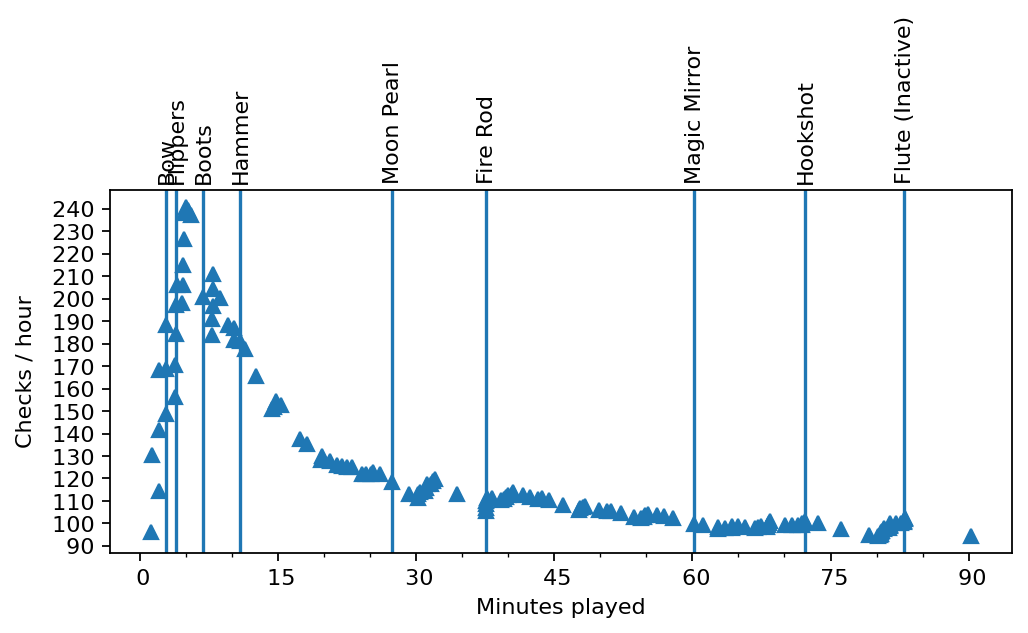

In [5]:
graph_progression(games[0])